Epoch 1/20:
  Train Loss: 0.8641, Dice: 0.0989, Accuracy: 113.6608
  Val Loss: 0.7471, Dice: 0.1082, Accuracy: 120.3716
Epoch 2/20:
  Train Loss: 0.5947, Dice: 0.3074, Accuracy: 124.1583
  Val Loss: 0.5144, Dice: 0.2457, Accuracy: 124.0076
Epoch 3/20:
  Train Loss: 0.4712, Dice: 0.3876, Accuracy: 124.6916
  Val Loss: 0.4521, Dice: 0.3363, Accuracy: 124.7012
Epoch 4/20:
  Train Loss: 0.4389, Dice: 0.4412, Accuracy: 124.8591
  Val Loss: 0.4598, Dice: 0.2961, Accuracy: 124.2462
Epoch 5/20:
  Train Loss: 0.4238, Dice: 0.4499, Accuracy: 124.9129
  Val Loss: 0.4132, Dice: 0.4867, Accuracy: 125.0397
Epoch 6/20:
  Train Loss: 0.4141, Dice: 0.4474, Accuracy: 124.8649
  Val Loss: 0.4305, Dice: 0.4451, Accuracy: 125.1014
Epoch 7/20:
  Train Loss: 0.4041, Dice: 0.4768, Accuracy: 124.9191
  Val Loss: 0.4213, Dice: 0.4985, Accuracy: 125.1559
Epoch 8/20:
  Train Loss: 0.3899, Dice: 0.4757, Accuracy: 124.9256
  Val Loss: 0.4456, Dice: 0.6033, Accuracy: 125.4046
Epoch 9/20:
  Train Loss: 0.3792, Dice: 

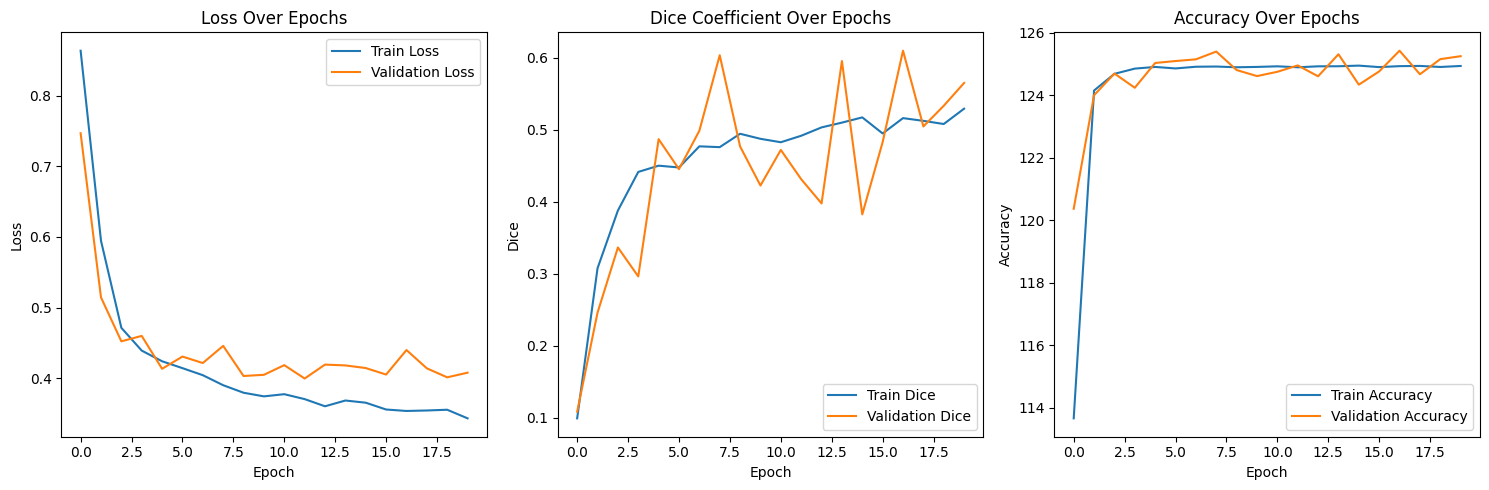

Sample 1:
Ground truth mask min: 0.0, max: 1.0
Predicted mask min: False, max: True
Sample 2:
Ground truth mask min: 0.0, max: 1.0
Predicted mask min: False, max: True
Sample 3:
Ground truth mask min: 0.0, max: 1.0
Predicted mask min: False, max: True


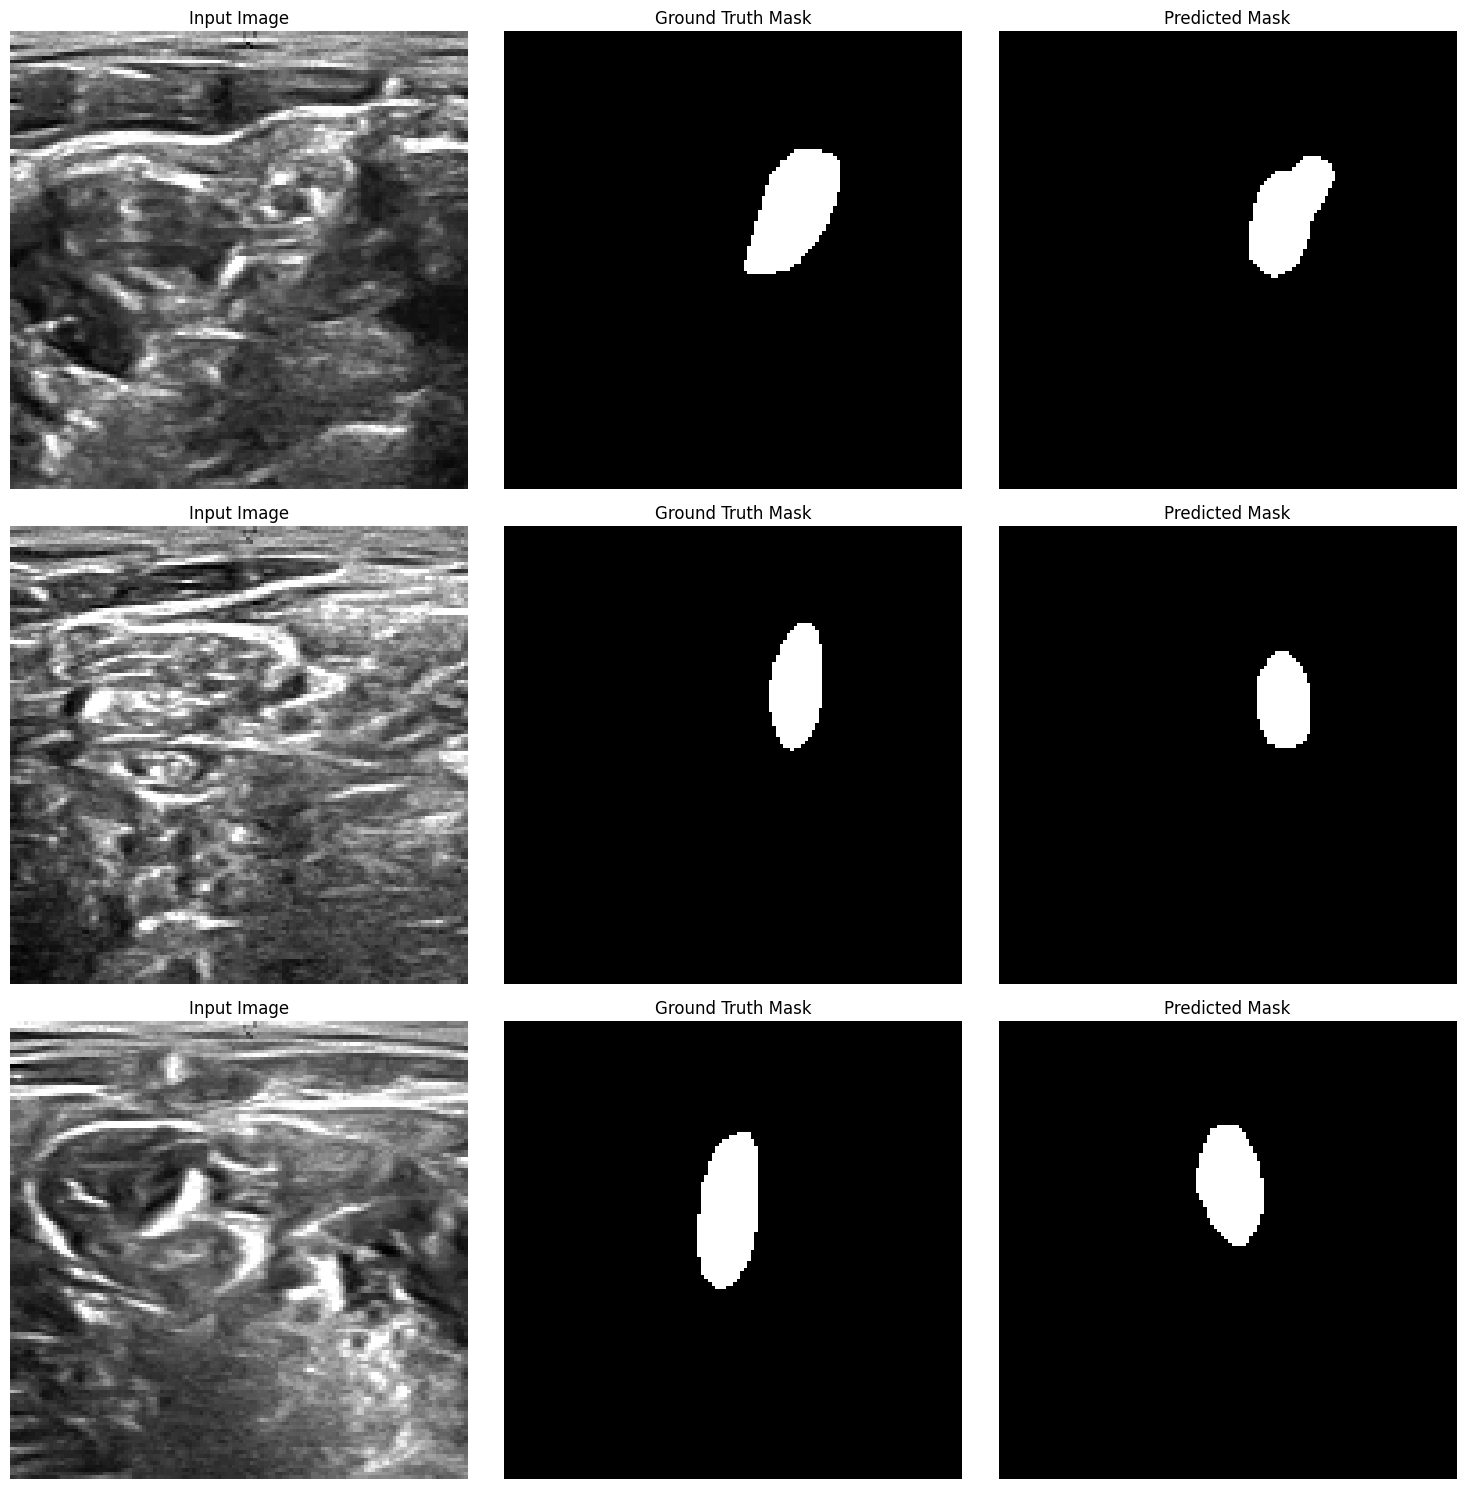

Training complete. Models saved as 'best_unet_nerve_segmentation.pth' and 'final_unet_nerve_segmentation.pth'.


In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image

# Configuration
IMG_SIZE = (128, 128)
BATCH_SIZE = 16
NUM_CLASSES = 1  # Binary segmentation (background vs. nerve)
EPOCHS = 20
LR_INITIAL = 1e-4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Paths
TRAIN_DIR = '/kaggle/input/ultrasound-nerve-segmentation/train'
TEST_DIR = '/kaggle/input/ultrasound-nerve-segmentation/test'

# Data Augmentation
train_transform = A.Compose([
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

# Dataset Class
class NerveDataset(Dataset):
    def __init__(self, img_ids, transform=None):
        self.img_ids = img_ids
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_path = os.path.join(TRAIN_DIR, f"{img_id}.tif")
        mask_path = os.path.join(TRAIN_DIR, f"{img_id}_mask.tif")
        
        image = np.array(Image.open(img_path))
        mask = np.array(Image.open(mask_path)) / 255.0  # Normalize to [0,1]
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        return image, mask

# Prepare Data
all_img_ids = [f.split('.')[0] for f in os.listdir(TRAIN_DIR) if f.endswith('.tif') and not f.endswith('_mask.tif')]
train_img_ids, val_img_ids = train_test_split(all_img_ids, test_size=0.2, random_state=42)

train_dataset = NerveDataset(train_img_ids, transform=train_transform)
val_dataset = NerveDataset(val_img_ids, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Model: U-Net with ResNet34 backbone
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,  # Grayscale images
    classes=NUM_CLASSES,
).to(DEVICE)

# Loss Function: Dice Loss for binary segmentation
criterion = smp.losses.DiceLoss(mode='binary')

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LR_INITIAL)

# Corrected Metric Functions
def dice_coefficient(preds, targets, smooth=1e-6):
    preds = torch.sigmoid(preds)  # Convert logits to probabilities
    preds = (preds > 0.5).float()  # Threshold to binary
    targets = targets.float()
    intersection = (preds * targets).sum(dim=(2, 3))
    union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()  # Average over batch

def pixel_accuracy(preds, targets):
    preds = torch.sigmoid(preds) > 0.5  # Threshold to binary
    correct = (preds == targets).float().sum()
    total = targets.numel()
    return correct / total

# Training Loop with Metrics
train_losses = []
val_losses = []
train_dices = []
val_dices = []
train_accuracies = []
val_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    train_dice = 0.0
    train_acc = 0.0
    
    for images, masks in train_loader:
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_dice += dice_coefficient(outputs, masks).item()
        train_acc += pixel_accuracy(outputs, masks).item()

    avg_train_loss = train_loss / len(train_loader)
    avg_train_dice = train_dice / len(train_loader)
    avg_train_acc = train_acc / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    val_acc = 0.0
    
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            val_loss += loss.item()
            val_dice += dice_coefficient(outputs, masks).item()
            val_acc += pixel_accuracy(outputs, masks).item()

    avg_val_loss = val_loss / len(val_loader)
    avg_val_dice = val_dice / len(val_loader)
    avg_val_acc = val_acc / len(val_loader)

    # Store metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_dices.append(avg_train_dice)
    val_dices.append(avg_val_dice)
    train_accuracies.append(avg_train_acc)
    val_accuracies.append(avg_val_acc)

    # Print progress
    print(f"Epoch {epoch+1}/{EPOCHS}:")
    print(f"  Train Loss: {avg_train_loss:.4f}, Dice: {avg_train_dice:.4f}, Accuracy: {avg_train_acc:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}, Dice: {avg_val_dice:.4f}, Accuracy: {avg_val_acc:.4f}")

    # Save best model based on validation Dice
    if len(val_dices) == 1 or avg_val_dice > max(val_dices[:-1]):
        torch.save(model.state_dict(), 'best_unet_nerve_segmentation.pth')

# Plotting Metrics
plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Dice Coefficient
plt.subplot(1, 3, 2)
plt.plot(train_dices, label='Train Dice')
plt.plot(val_dices, label='Validation Dice')
plt.title('Dice Coefficient Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()

# Plot Accuracy
plt.subplot(1, 3, 3)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Visualize Validation Examples with Non-Zero Masks
model.eval()
num_examples = 3  # Show 3 examples with nerve structures
val_iter = iter(val_loader)
fig, axes = plt.subplots(num_examples, 3, figsize=(15, 5 * num_examples))

example_count = 0
with torch.no_grad():
    while example_count < num_examples:
        images, masks = next(val_iter)
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        outputs = model(images)
        preds = torch.sigmoid(outputs) > 0.5

        for i in range(images.size(0)):
            mask = masks[i].cpu().numpy().squeeze()
            if mask.max() > 0:  # Only select samples with nerve structures
                img = images[i].cpu().numpy().squeeze()
                pred = preds[i].cpu().numpy().squeeze()

                # Debug: Print values
                print(f"Sample {example_count + 1}:")
                print(f"Ground truth mask min: {mask.min()}, max: {mask.max()}")
                print(f"Predicted mask min: {pred.min()}, max: {pred.max()}")

                # Plot input image
                axes[example_count, 0].imshow(img, cmap='gray')
                axes[example_count, 0].set_title('Input Image')
                axes[example_count, 0].axis('off')

                # Plot ground truth mask
                axes[example_count, 1].imshow(mask, cmap='gray')
                axes[example_count, 1].set_title('Ground Truth Mask')
                axes[example_count, 1].axis('off')

                # Plot predicted mask
                axes[example_count, 2].imshow(pred, cmap='gray')
                axes[example_count, 2].set_title('Predicted Mask')
                axes[example_count, 2].axis('off')

                example_count += 1
                if example_count >= num_examples:
                    break

plt.tight_layout()
plt.show()

# Save final model
torch.save(model.state_dict(), 'final_unet_nerve_segmentation.pth')
print("Training complete. Models saved as 'best_unet_nerve_segmentation.pth' and 'final_unet_nerve_segmentation.pth'.")

In [2]:
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 8.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=eb8149beae809f8329fc96e6b6c2e83f127a9b680de89ac48d335772e4c4f212
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=cc3c6b015d64fc9d5f081d6fc63e33904e0ab7b1b2d3d9f722b655baec67b4c9
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 230MB/s]


Epoch 1/50:
  Train Loss: 0.9229, Dice: 0.1390, Accuracy: 0.7904
  Val Loss: 0.8364, Dice: 0.3744, Accuracy: 0.9769
Epoch 2/50:
  Train Loss: 0.7238, Dice: 0.3884, Accuracy: 0.9753
  Val Loss: 0.5983, Dice: 0.5747, Accuracy: 0.9884
Epoch 3/50:
  Train Loss: 0.5417, Dice: 0.5170, Accuracy: 0.9865
  Val Loss: 0.4767, Dice: 0.6038, Accuracy: 0.9898
Epoch 4/50:
  Train Loss: 0.4761, Dice: 0.5711, Accuracy: 0.9882
  Val Loss: 0.4455, Dice: 0.6011, Accuracy: 0.9898
Epoch 5/50:
  Train Loss: 0.4428, Dice: 0.6042, Accuracy: 0.9891
  Val Loss: 0.4398, Dice: 0.6279, Accuracy: 0.9887
Epoch 6/50:
  Train Loss: 0.4399, Dice: 0.6067, Accuracy: 0.9891
  Val Loss: 0.4453, Dice: 0.5269, Accuracy: 0.9868
Epoch 7/50:
  Train Loss: 0.4276, Dice: 0.6050, Accuracy: 0.9894
  Val Loss: 0.4139, Dice: 0.6596, Accuracy: 0.9903
Epoch 8/50:
  Train Loss: 0.4139, Dice: 0.6274, Accuracy: 0.9897
  Val Loss: 0.4085, Dice: 0.6680, Accuracy: 0.9906
Epoch 9/50:
  Train Loss: 0.4097, Dice: 0.6463, Accuracy: 0.9900
  Val L

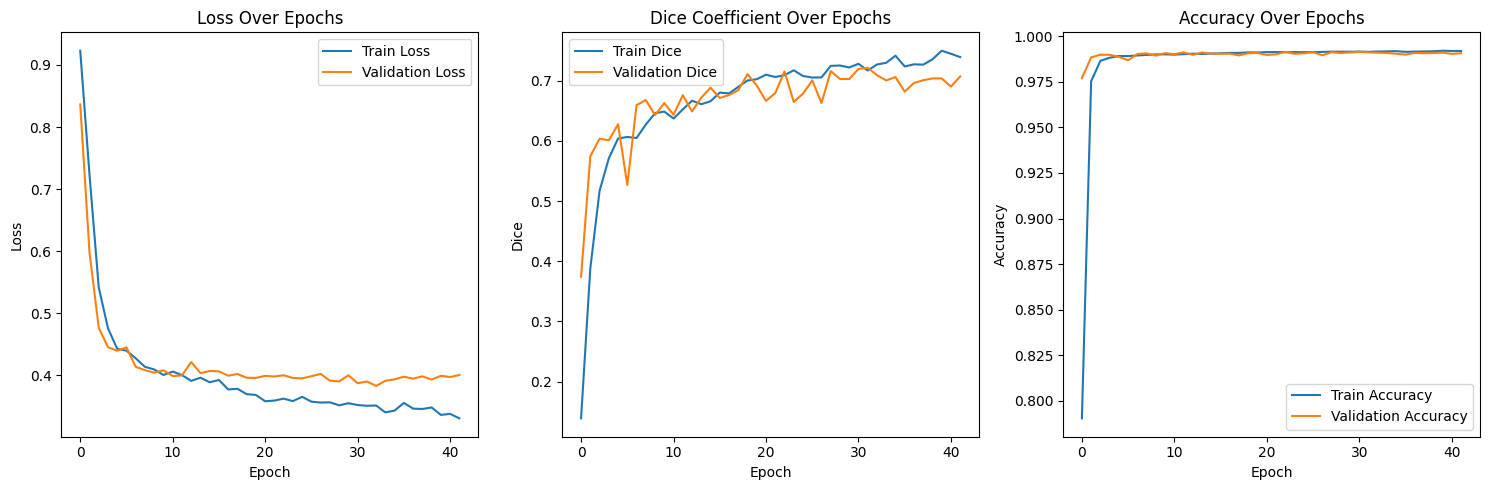

Sample 1:
Ground truth mask min: 0.0, max: 1.0
Predicted mask min: False, max: True
Sample 2:
Ground truth mask min: 0.0, max: 1.0
Predicted mask min: False, max: True
Sample 3:
Ground truth mask min: 0.0, max: 1.0
Predicted mask min: False, max: True


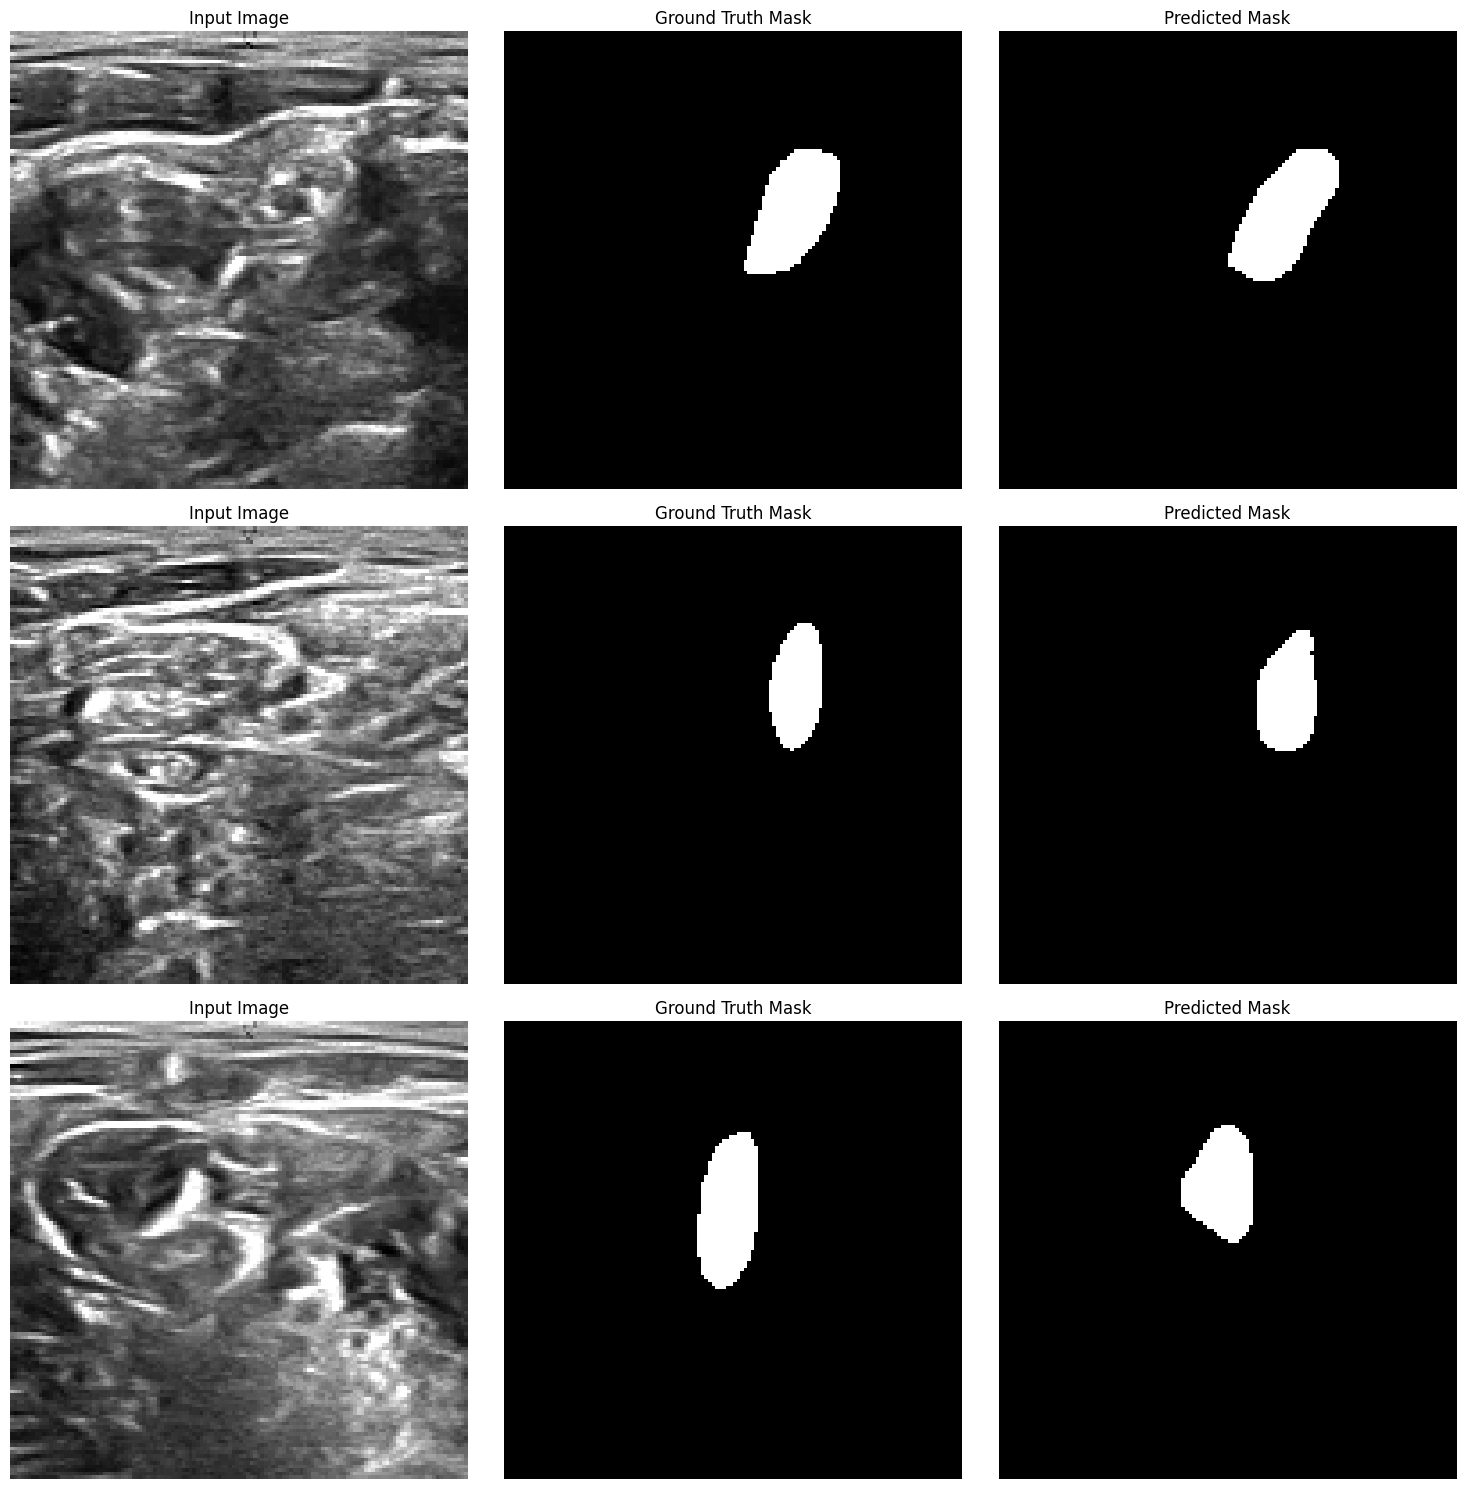

Training complete. Models saved as 'best_unet_nerve_segmentation.pth' and 'final_unet_nerve_segmentation.pth'.


In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image

# Configuration
IMG_SIZE = (128, 128)
BATCH_SIZE = 16
NUM_CLASSES = 1  # Binary segmentation (background vs. nerve)
EPOCHS = 50  # Increased for better convergence
LR_INITIAL = 1e-4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TRAIN_DIR = '/kaggle/input/ultrasound-nerve-segmentation/train'

# Data Augmentation
train_transform = A.Compose([
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),  # Added
    A.GaussNoise(p=0.3),  # Added
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

# Dataset Class
class NerveDataset(Dataset):
    def __init__(self, img_ids, transform=None):
        self.img_ids = img_ids
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_path = os.path.join(TRAIN_DIR, f"{img_id}.tif")
        mask_path = os.path.join(TRAIN_DIR, f"{img_id}_mask.tif")
        
        image = np.array(Image.open(img_path))
        mask = np.array(Image.open(mask_path)) / 255.0  # Normalize to [0,1]
        mask = np.expand_dims(mask, axis=-1)  # [H, W, 1]

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']  # [1, H, W]
            mask = augmented['mask']
            # Ensure mask is [1, H, W] if not transposed correctly by ToTensorV2
            if mask.ndim == 3 and mask.shape[0] == IMG_SIZE[0]:  # [H, W, 1]
                mask = mask.permute(2, 0, 1)

        return image, mask

# Prepare Data
all_img_ids = [f.split('.')[0] for f in os.listdir(TRAIN_DIR) if f.endswith('.tif') and not f.endswith('_mask.tif')]
train_img_ids, val_img_ids = train_test_split(all_img_ids, test_size=0.2, random_state=42)

train_dataset = NerveDataset(train_img_ids, transform=train_transform)
val_dataset = NerveDataset(val_img_ids, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Model: U-Net with ResNet34 backbone
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,  # Grayscale images
    classes=NUM_CLASSES,
).to(DEVICE)

# Loss Function: Dice Loss for binary segmentation
criterion = smp.losses.DiceLoss(mode='binary')

# Optimizer and Scheduler
optimizer = optim.Adam(model.parameters(), lr=LR_INITIAL)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

# Metric Functions (unchanged)
def dice_coefficient(preds, targets, smooth=1e-6):
    preds = torch.sigmoid(preds)  # Convert logits to probabilities
    preds = (preds > 0.5).float()  # Threshold to binary
    targets = targets.float()
    intersection = (preds * targets).sum(dim=(2, 3))
    union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()  # Average over batch

def pixel_accuracy(preds, targets):
    preds = torch.sigmoid(preds) > 0.5  # Threshold to binary
    correct = (preds == targets).float().sum()
    total = targets.numel()
    return correct / total

# Training Loop with Metrics
train_losses = []
val_losses = []
train_dices = []
val_dices = []
train_accuracies = []
val_accuracies = []

best_val_dice = 0.0
patience = 10
trigger_times = 0

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    train_dice = 0.0
    train_acc = 0.0
    
    for images, masks in train_loader:
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_dice += dice_coefficient(outputs, masks).item()
        train_acc += pixel_accuracy(outputs, masks).item()

    avg_train_loss = train_loss / len(train_loader)
    avg_train_dice = train_dice / len(train_loader)
    avg_train_acc = train_acc / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    val_acc = 0.0
    
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            val_loss += loss.item()
            val_dice += dice_coefficient(outputs, masks).item()
            val_acc += pixel_accuracy(outputs, masks).item()

    avg_val_loss = val_loss / len(val_loader)
    avg_val_dice = val_dice / len(val_loader)
    avg_val_acc = val_acc / len(val_loader)

    # Store metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_dices.append(avg_train_dice)
    val_dices.append(avg_val_dice)
    train_accuracies.append(avg_train_acc)
    val_accuracies.append(avg_val_acc)

    # Scheduler step
    scheduler.step(avg_val_loss)

    # Print progress
    print(f"Epoch {epoch+1}/{EPOCHS}:")
    print(f"  Train Loss: {avg_train_loss:.4f}, Dice: {avg_train_dice:.4f}, Accuracy: {avg_train_acc:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}, Dice: {avg_val_dice:.4f}, Accuracy: {avg_val_acc:.4f}")

    # Save best model based on validation Dice
    if avg_val_dice > best_val_dice:
        best_val_dice = avg_val_dice
        torch.save(model.state_dict(), 'best_unet_nerve_segmentation.pth')
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break

# Plotting Metrics
plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Dice Coefficient
plt.subplot(1, 3, 2)
plt.plot(train_dices, label='Train Dice')
plt.plot(val_dices, label='Validation Dice')
plt.title('Dice Coefficient Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()

# Plot Accuracy
plt.subplot(1, 3, 3)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Visualize Validation Examples with Non-Zero Masks
model.eval()
num_examples = 3  # Show 3 examples with nerve structures
val_iter = iter(val_loader)
fig, axes = plt.subplots(num_examples, 3, figsize=(15, 5 * num_examples))

example_count = 0
with torch.no_grad():
    while example_count < num_examples:
        images, masks = next(val_iter)
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        outputs = model(images)
        preds = torch.sigmoid(outputs) > 0.5

        for i in range(images.size(0)):
            mask = masks[i].cpu().numpy().squeeze()
            if mask.max() > 0:  # Only select samples with nerve structures
                img = images[i].cpu().numpy().squeeze()
                pred = preds[i].cpu().numpy().squeeze()

                # Debug: Print values
                print(f"Sample {example_count + 1}:")
                print(f"Ground truth mask min: {mask.min()}, max: {mask.max()}")
                print(f"Predicted mask min: {pred.min()}, max: {pred.max()}")

                # Plot input image
                axes[example_count, 0].imshow(img, cmap='gray')
                axes[example_count, 0].set_title('Input Image')
                axes[example_count, 0].axis('off')

                # Plot ground truth mask
                axes[example_count, 1].imshow(mask, cmap='gray')
                axes[example_count, 1].set_title('Ground Truth Mask')
                axes[example_count, 1].axis('off')

                # Plot predicted mask
                axes[example_count, 2].imshow(pred, cmap='gray')
                axes[example_count, 2].set_title('Predicted Mask')
                axes[example_count, 2].axis('off')

                example_count += 1
                if example_count >= num_examples:
                    break

plt.tight_layout()
plt.show()

# Save final model
torch.save(model.state_dict(), 'final_unet_nerve_segmentation.pth')
print("Training complete. Models saved as 'best_unet_nerve_segmentation.pth' and 'final_unet_nerve_segmentation.pth'.")